# Curve fitting in HyperSpy:
## Applications to EELS data analysis

### <br/>
### Josh Taillon and Andy Herzing
#### *April 5, 2018*

In [1]:
%matplotlib notebook
import hyperspy.api as hs
import numpy as np
import matplotlib.pylab as plt

In [ ]:
import logging
hs_logger = logging.getLogger('hyperspy') 
hs_logger.setLevel(logging.ERROR)

## Create some test data
- 50x50 array of Gaussians with randomly varying A, mu, and sigma

In [2]:
amps = hs.signals.Signal2D(np.random.randint(500,1500,size=[20,20]))
centers = hs.signals.Signal2D(np.random.randint(45,55,size=[20,20]))
sigmas = hs.signals.Signal2D(np.random.randint(5,10,size=[20,20]))

xaxis = np.tile(np.arange(0,100),20**2)
xaxis = xaxis.reshape([20,20,100])
xaxis = np.rollaxis(xaxis,2)
curves = amps.data/np.sqrt(2*np.pi*sigmas.data**2)*np.exp(-(xaxis-centers.data)**2/(2*sigmas.data**2))
curves = np.rollaxis(curves,0,3)
gaussians = hs.signals.Signal1D(curves)

gaussians

<Signal1D, title: , dimensions: (20, 20|100)>

<IPython.core.display.Javascript object>


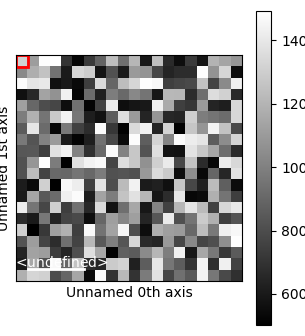

<IPython.core.display.Javascript object>


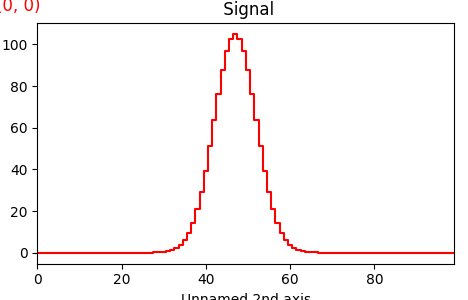

In [3]:
gaussians.plot()

## Create a model

In [4]:
gaussians_model = gaussians.create_model()
gaussians_model.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

Add single Gaussian component:

In [5]:
gaussians_model.append(hs.model.components1D.Gaussian())
gaussians_model[0].estimate_parameters(gaussians,10,90,False)
gaussians_model.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian

Perform fit at all pixel locations:

<IPython.core.display.Javascript object>


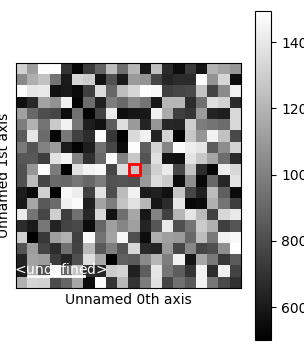

<IPython.core.display.Javascript object>


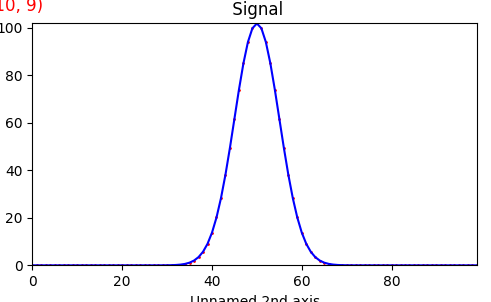

In [6]:
gaussians_model.multifit()
gaussians_model.plot()

## Compare fitted values to test data


<IPython.core.display.Javascript object>


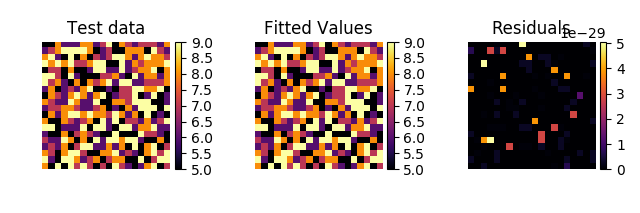

In [7]:
sig_results = gaussians_model.components.Gaussian.parameters[1].as_signal()
residuals = (sig_results-sigmas)**2

hs.plot.plot_images([sigmas, sig_results, residuals], cmap='inferno',
                    axes_decor='off', tight_layout=True, 
                    label=['Test data', 'Fitted Values', 'Residuals'])
plt.tight_layout()

## Add some noise to the test data

In [8]:
noisy = gaussians.deepcopy()
noisy.unfold()

for i in range(0,20**2):
    noisy.data[i,:] =noisy.data[i,:] + np.random.poisson(np.sqrt(noisy.data[i,:].max()),100)
noisy.fold()

## Modeling the noisy data

Create model and add a single Gaussian component:

In [9]:
noisy_model = noisy.create_model()
noisy_model.append(hs.model.components1D.Gaussian())

Add a linear offset to account for 'background' from adding noise:

In [10]:
noisy_model.append(hs.model.components1D.Offset())

Estimate model parameters using a quick arithmetic estimation:

In [11]:
noisy_model['Gaussian'].estimate_parameters(signal=noisy, x1=10, x2=90, only_current=False)
noisy_model['Offset'].estimate_parameters(signal=noisy, x1=10, x2=90, only_current=False);

Perform fit at all image pixels:

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

<IPython.core.display.Javascript object>


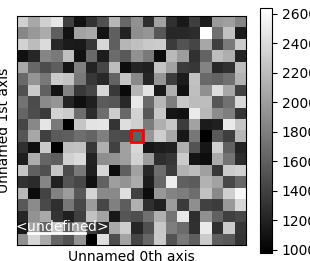

<IPython.core.display.Javascript object>


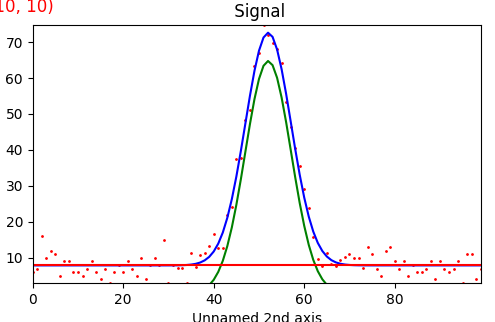

In [12]:
noisy_model.multifit(show_progressbar=True)
noisy_model.plot(plot_components=True)

# More Realistic Application:

## Fitting EELS Fine Structure

## Useful aside: The EELS Database

<img src='EELSdb_logo-medium.png' width='500' align='center'/>

- https://eelsdb.eu/
    - Largest open-access repository of EELS and X-ray absorption spectra
    - Nearly 300 spectra covering 43 elements and growing
- Database can be directly queried by:
    - `title` &mdash; "Hexagonal Boron Nitride"
    - `formula` &mdash; "BN"
    - `element` &mdash; "B,N"
    - `edge` &mdash; "K" or "L1"
    - Etc., many other options

Spectra can be pulled directly from database into HyperSpy (requires internet connection):

In [13]:
# Search by formula:
hs.datasets.eelsdb(formula='BN')

[<EELSSpectrum, title: Boron nitride, dimensions: (|1002)>,
 <EELSSpectrum, title: boron nitride, dimensions: (|837)>,
 <EELSSpectrum, title: Boron Nitride single wall nanotube, dimensions: (|1256)>,
 <EELSSpectrum, title: Boron Nitride multiwall nanotube, dimensions: (|786)>,
 <EELSSpectrum, title: Boron Nitride multiwall nanotube, dimensions: (|792)>,
 <EELSSpectrum, title: Boron Nitride single wall nanotube, dimensions: (|561)>,
 <EELSSpectrum, title: Boron Nitride triple wall nanotube, dimensions: (|546)>,
 <EELSSpectrum, title: Hexagonal Boron Nitride, dimensions: (|1024)>,
 <EELSSpectrum, title: Hexagonal Boron Nitride, dimensions: (|1024)>,
 <EELSSpectrum, title: Cubic boron nitride, dimensions: (|946)>,
 <EELSSpectrum, title: Cubic boron nitride, dimensions: (|812)>]

In [14]:
# Search my element and spectrum type:
hs.datasets.eelsdb(element=('Fe','O'), spectrum_type='coreloss')

[<EELSSpectrum, title: Iron (III) oxide, hematite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide, dimensions: (|1024)>,
 <EELSSpectrum, title: Hematite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide Hematite, dimensions: (|926)>,
 <EELSSpectrum, title: Iron Oxide Hematite, dimensions: (|620)>,
 <EELSSpectrum, title: Ti-ferrite (spinel), dimensions: (|780)>,
 <EELSSpectrum, title: Ti-ferrite (spinel), dimensions: (|780)>,
 <EELSSpectrum, title: Iron Oxide Magnetite, dimensions: (|911)>,
 <EELSSpectrum, title: Iron Oxide Magnetite, dimensions: (|629)>,
 <EELSSpectrum, title: Iron Oxide Siderite, dimensions: (|826)>,
 <EELSSpectrum, title: Iron Oxide Siderite, dimensions: (|605)>,
 <EELSSpectrum, title: Iron Oxide 2-lines ferrihydrite, dimensions: (|671)>,
 <EELSSpectrum, title: Iron Oxide 2-lines ferrihydrite, dimensions: (|660)>,
 <EELSSpectrum, title: Iron Oxide Goethite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide Goethite, dimensions: (|704)>,
 <EELSSp

# Back to the demo...

## Load data downloaded from EELS Database

Core-loss and low-loss boron nitride spectra:

In [15]:
s = hs.datasets.eelsdb(title="Hexagonal Boron Nitride", spectrum_type="coreloss")[0]
ll = hs.datasets.eelsdb(title="Hexagonal Boron Nitride", spectrum_type="lowloss")[0]

### If no internet:
#s = hs.load("examples/BN_(hex)_B_K_Giovanni_Bertoni_100.msa")
#ll = hs.load("examples/BN_(hex)_LowLoss_Giovanni_Bertoni_96.msa")

Set microscope parameters:

In [16]:
s.set_microscope_parameters(beam_energy=100, convergence_angle=0.2, collection_angle=2.55)

Add Boron and Nitrogen to model:

In [17]:
s.add_elements(('B', 'N'))

Create model:

  * Automatically adds PowerLaw component to fit background
  * Automatically adds relevant edges in the energy range of the spectrum
  

In [18]:
m = s.create_model(ll=ll)
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |                 N_K |                 N_K |          EELSCLEdge
   2 |                 B_K |                 B_K |          EELSCLEdge

<IPython.core.display.Javascript object>


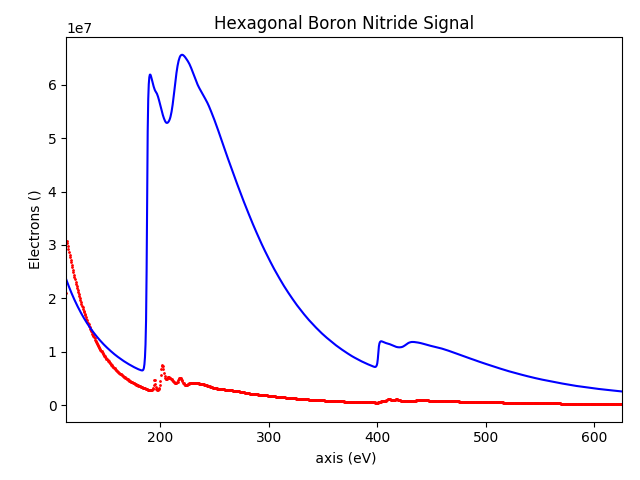

In [19]:
m.plot()

## Perform least squares fitting to data

<IPython.core.display.Javascript object>


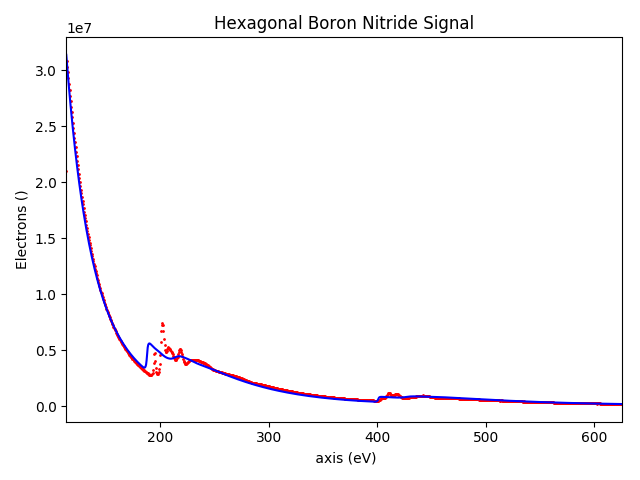

In [20]:
m.smart_fit()
m.plot()

## Perform least-squares fitting with fine structure

- Requires local database of ionization cross-sections

- HyperSpy uses values calculated using Egerton's `sigmak3` and `sigmal3` routines

- Better ones come with DigitalMicrograph, and HyperSpy can use those files:
    - Not open-source, so cannot be distributed

In [ ]:
# To change to Gatan's GOS files:
### hs.preferences.EELS.eels_gos_files_path = <path to GOS tables>

In [21]:
m.enable_fine_structure()
m.smart_fit()

<IPython.core.display.Javascript object>


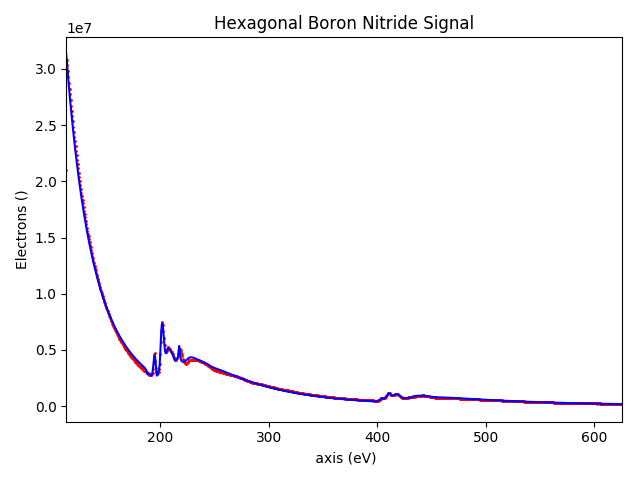

In [22]:
m.plot()

## Questions?

Next demo: [Processing TEM EDS data](TEM_EDS_nanoparticles.ipynb)